# Praca domowa z ML numer 3

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#### W tej pracy domowej oszacujemy dwa modele regresji logistycznej na dwóch różnych bazach danych w celu identyfikacji różnych progów odcięcia (thresholds) w zależności od celu, który będziemy chcieli osiągnąć. Pierwsza baza danych to dosyć popularna baza danych dotycząca raka piersi u pacjentek. Dane są podzielone na dwie grupy. Jedna grupa to pacjentki, u których wykryto nowotwór złośliwy, a druga grupa to pacjentki, u których nowotwór okazał się nie być złośliwy. 

#### Druga baza danych dotyczy filtrowania spamu i pochodzi z Kaggle. Baza składa się ze sporej ilości obserwacji, a kolumny to częstotliwość używania najpopularniejszych wyrazów. 

#### Bazy danych zostały tak dobrane, aby spojerzeć na zadanie wyznaczenia odpowiedniego progu w regresji logistycznej na dwa sposoby. Z jednej strony, dla danych medycznych, gdzie lepiej jest zaklasyfikować pacjentkę jako chorującą, nawet jeśli tak nie jest (bo można przeprowadzić dodatkowe testy i ewentualnie wykluczyć chorbę) niż zdrową, kiedy w rzeczywsitości jest chora. W przypadku wychwytywania spamu, nie chcemy oznaczyć wiadomości jako spam, jeśli spamemn nie była.

## Dane oraz ich obróbka

In [2]:
spam_data = pd.read_csv("emails.csv")
cancer_data = pd.read_csv("data-2.csv")

#zapewnienie powtarzalności wyników
np.random.seed(0)

In [3]:
#obróbka danych
cancer_data.drop(columns = ["id" , "Unnamed: 32"], inplace = True)
#przyjmujemy oznaczenia M (malicious) -> 1, B (benign) -> 0
cancer_data["diagnosis"] = cancer_data["diagnosis"].apply(lambda x: 1 if x == "M" else 0)
#usuwanie NaN
cancer_data = cancer_data.dropna()
cancer_data.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


#### Dane do filtrowania spamu mają sporo kolumn, więc można ewentualnie zastosować PCA do znalezienia najważniejszych elementów. Zoabczymy jak długo model będzie się liczył

In [4]:
spam_data.drop(columns = ["Email No."], inplace = True)
spam_data = spam_data.dropna()
spam_data.describe()

,the,to,ect,and,for,of,a,you,hou,in,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
count,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,...,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000
mean,6.640565,6.188128,5.143852,3.075599,3.124710,2.627030,55.517401,2.466551,2.024362,10.600155,...,0.005027,0.012568,0.010634,0.098028,0.004254,0.006574,0.004060,0.914733,0.006961,0.290023
std,11.745009,9.534576,14.101142,6.045970,4.680522,6.229845,87.574172,4.314444,6.967878,19.281892,...,0.105788,0.199682,0.116693,0.569532,0.096252,0.138908,0.072145,2.780203,0.098086,0.453817
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,12.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,3.000000,1.000000,1.000000,2.000000,1.000000,28.000000,1.000000,0.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.000000,7.000000,4.000000,3.000000,4.000000,2.000000,62.250000,3.000000,1.000000,12.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,210.000000,132.000000,344.000000,89.000000,47.000000,77.000000,1898.000000,70.000000,167.000000,223.000000,...,4.000000,7.000000,2.000000,12.000000,3.000000,4.000000,3.000000,114.000000,4.000000,1.000000


#### Podzielimy teraz na dane testowe, walidacyjne oraz treningowe

In [5]:
y_spam = spam_data["Prediction"]
X_spam = spam_data.iloc[:, :-1]
#podział 60% tranowanie, 20% walidacja, 20% test
X_spam_train, X_spam_test, y_spam_train, y_spam_test = train_test_split(X_spam, y_spam, test_size = 0.2)
X_spam_train, X_spam_val, y_spam_train, y_spam_val = train_test_split(X_spam_train, y_spam_train, test_size = 0.25)

In [6]:
y_cancer = cancer_data["diagnosis"]
X_cancer = cancer_data.iloc[:, 1:]
#podział 60% tranowanie, 20% walidacja, 20% test
X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = train_test_split(X_cancer, y_cancer, test_size = 0.2)
X_cancer_train, X_cancer_val, y_cancer_train, y_cancer_val = train_test_split(X_cancer_train, y_cancer_train, test_size = 0.25)


#### Trenowanie modelu

In [7]:
#problemy ze zbieżnością, więć zwiększono max iter w obu modelach
spam_model = LogisticRegression(solver = "lbfgs" ,max_iter = 10000)
spam_model.fit(X_spam_train, y_spam_train)

LogisticRegression(max_iter=10000)

In [8]:
cancer_model = LogisticRegression(solver = "lbfgs" ,max_iter = 10000)
cancer_model.fit(X_cancer_train, y_cancer_train)

LogisticRegression(max_iter=10000)

## Krzywe ROC i wartości AUC

#### Bardzo często w przypadku próby identyfikacji odpowiednich progów odcięcia w regresji logistycznej stosuje się tzw. krzywą ROC. Krzywa ROC to wizualna reprezentacja wydajności modelu na wszystkich wartościach progowych. Idea stojąca za krzywą ROC polega na pokazaniu na wykresie jak wygląda współczynnik prawdziwe pozytywnych (True positives - TPR) względem współczynnika wyników fałszywie pozytywnych (False Positives FPR) przy różnych progach odcięcia. Poniżej wykres przykładowej krzywej.



(https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=pl). 

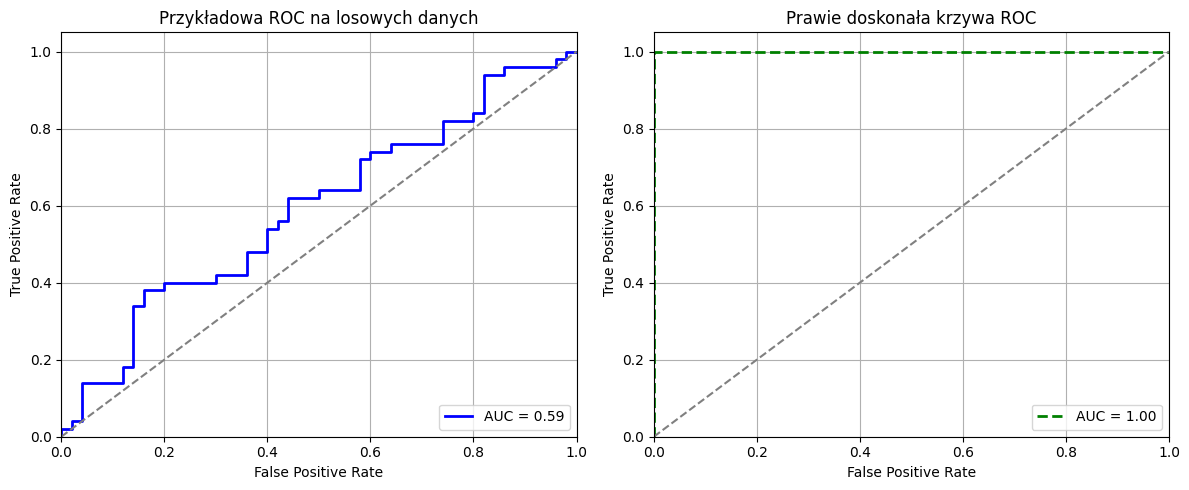

In [9]:
y_true_random = np.random.randint(0, 2, 100)
y_scores_random = np.random.rand(100)
fpr_random, tpr_random, _ = roc_curve(y_true_random, y_scores_random)
auc_random = auc(fpr_random, tpr_random)

y_true_better = np.concatenate([np.ones(50), np.zeros(50)]) 
y_scores_better = np.concatenate([np.linspace(0.7, 1.0, 50), np.linspace(0.0, 0.3, 50)])
fpr_better, tpr_better, _ = roc_curve(y_true_better, y_scores_better)
auc_better = auc(fpr_better, tpr_better)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(fpr_random, tpr_random, color='blue', lw=2, label=f'AUC = {auc_random:.2f}')
axes[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Przykładowa ROC na losowych danych')
axes[0].legend(loc='lower right')
axes[0].grid()

axes[1].plot(fpr_better, tpr_better, color='green', lw=2, linestyle='--', label=f'AUC = {auc_better:.2f}')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Prawie doskonała krzywa ROC')
axes[1].legend(loc='lower right')
axes[1].grid()

plt.tight_layout()
plt.show()


#### Im wykres jest bliższy kwadratowi jednostkowemu tym lepszy model, bo oznacza to, że nasz model poprawie identyfikuje (klasyfikuje) poszczególne obserwacje. Wykres linii 45 stopni wskazuje na losowe przyporządkowanie, a wykres poniżej tej linii pokazuje, że nasz klasyfikator działa gorzej niż losowe przypisanie poszczególnej klasy. Tutaj pojawia się też możliwość wyznaczenia punktów odcięcia. Jednym z ze stosowanych podejść jest identyfikacja progu, dla którego punkty na krzywej ROC są najblżej punktu (1,0). Intuicja stojąca za tym polega na znalezieniu progu odcięcia, przy którym klasyfikator jest najblżej perfekcyjengo klasyfikatora. Innym podejściem jest zastosowanie statystyki J Youdena zdefinowanej jako róznica między TPR i FPR. Wówczas znaleznienie odpowiedniego (odpwoiednich) progów odcięcia polega na maksymalizaji tej statyski względem poziomu odcięcia.

### Interpretacja AUC

#### AUC jest zdefiniowana jako pole pod wykresem krzywej ROC. Tę wartość interpretuje się jako prawdopodobieństwo, że dostając dwie (losowe) obserwacje pozytywną i negatywną, model wyżej sklasyfikuje obserwację pozytywną niż negatywną.

(https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

## Krzywe ROC i wartości AUC dla danych (do walidacji) z zadania

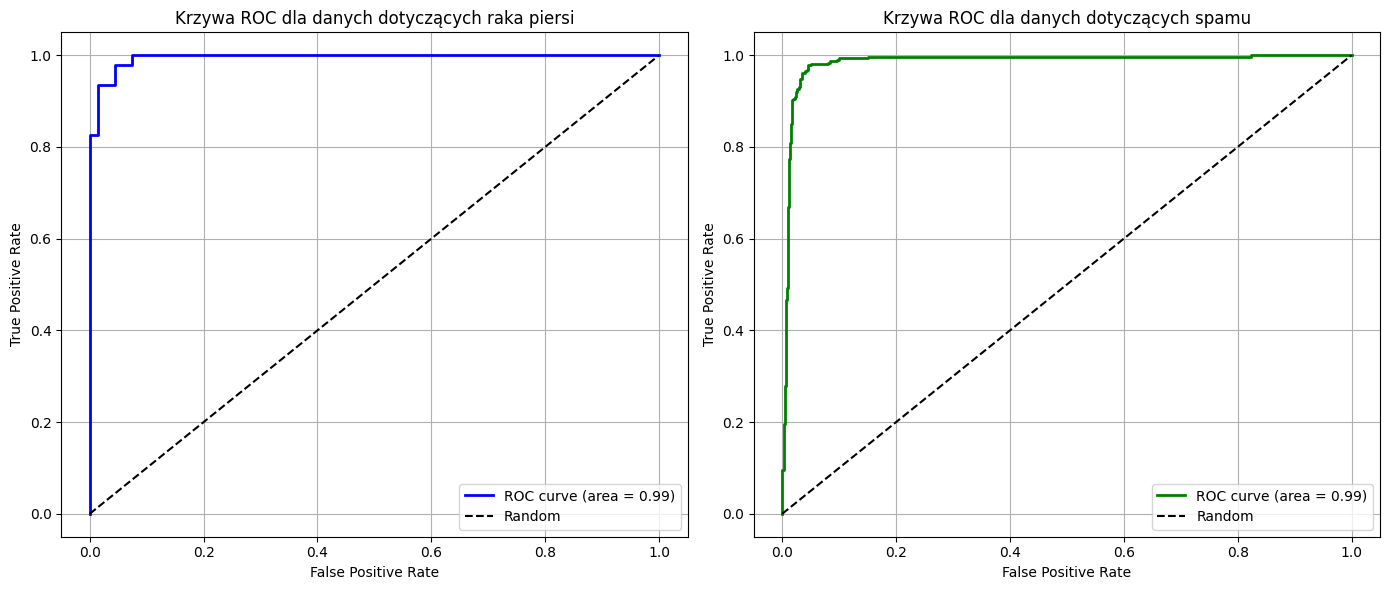

In [10]:
y_cancer_pred = cancer_model.predict_proba(X_cancer_val)[:, 1]
fpr_cancer, tpr_cancer, thresholds_cancer = metrics.roc_curve(y_cancer_val, y_cancer_pred)
roc_auc_cancer = metrics.auc(fpr_cancer, tpr_cancer)

y_spam_pred = spam_model.predict_proba(X_spam_val)[:, 1]
fpr_spam, tpr_spam, thresholds_spam = metrics.roc_curve(y_spam_val, y_spam_pred)
roc_auc_spam = metrics.auc(fpr_spam, tpr_spam)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(fpr_cancer, tpr_cancer, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_cancer:.2f})')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0].set_xlim([-0.05, 1.05])
axes[0].set_ylim([-0.05, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Krzywa ROC dla danych dotyczących raka piersi')
axes[0].legend(loc='lower right')
axes[0].grid()

axes[1].plot(fpr_spam, tpr_spam, color='green', lw=2, label=f'ROC curve (area = {roc_auc_spam:.2f})')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlim([-0.05, 1.05])
axes[1].set_ylim([-0.05, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Krzywa ROC dla danych dotyczących spamu')
axes[1].legend(loc='lower right')
axes[1].grid()

plt.tight_layout()
plt.show()

#### Zastosujemy podejście związane z maskymalizacją statysyki J Youdena. Wobec tego szukamy progu, który maksymalizuje szukaną wartość.

In [11]:
J_score_cancer = tpr_cancer - fpr_cancer
id_J_c = np.argmax(J_score_cancer)
best_th_cancer = thresholds_cancer[id_J_c]
print(best_th_cancer)


J_score_spam = tpr_spam - fpr_spam
id_J_s = np.argmax(J_score_spam)
best_th_spam = thresholds_spam[id_J_s]
print(best_th_spam)

0.053261854983821
0.3424454437540596


#### Tutaj podejście bazujące na szukaniu punktu najbliżej (0,1)

In [12]:
cancer_dist = (1-tpr_cancer)**2 + fpr_cancer**2
id_c_d = np.argmin(cancer_dist)
best_th_cancer_d = thresholds_cancer[id_c_d]
print(best_th_cancer_d)

spam_dist = (1-tpr_spam)**2 + fpr_spam**2
id_s_d = np.argmin(spam_dist)
best_th_spam_d = thresholds_spam[id_s_d]
print(best_th_spam_d)

0.053261854983821
0.3424454437540596


#### Jak widać progi się pokrywają przy obu podejściach (niekoniecznie tak musi być za każdym razem)

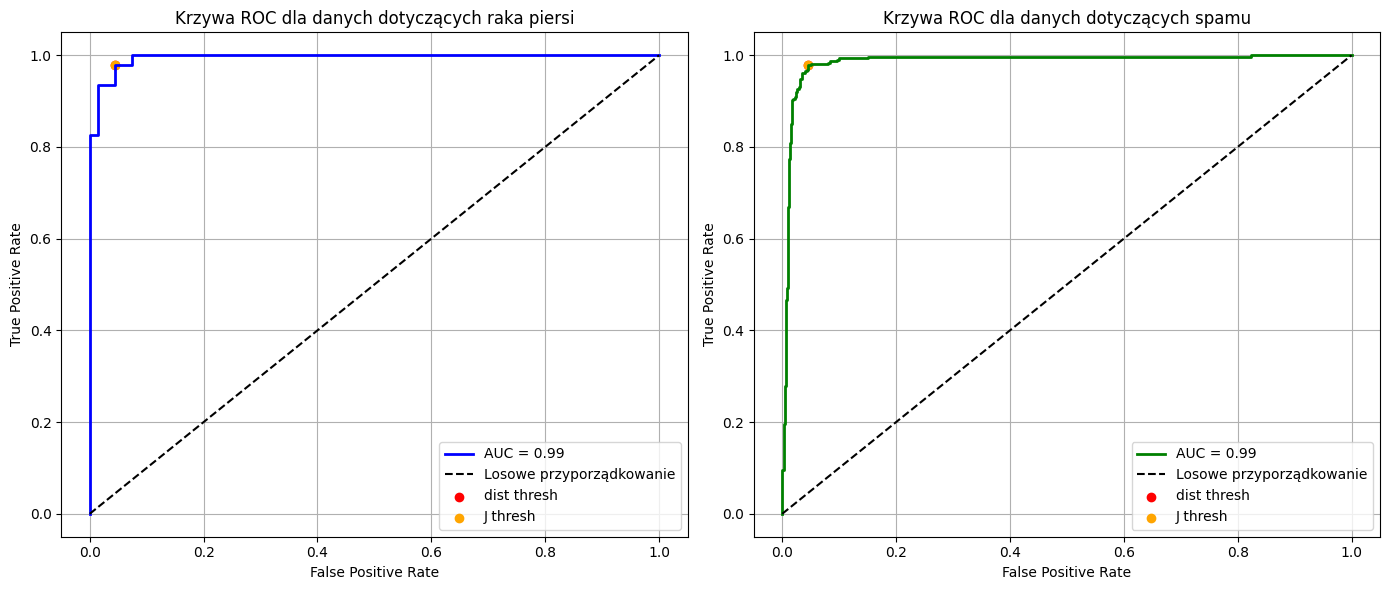

In [13]:
y_cancer_pred = cancer_model.predict_proba(X_cancer_val)[:, 1]
fpr_cancer, tpr_cancer, thresholds_cancer = metrics.roc_curve(y_cancer_val, y_cancer_pred)
roc_auc_cancer = metrics.auc(fpr_cancer, tpr_cancer)

y_spam_pred = spam_model.predict_proba(X_spam_val)[:, 1]
fpr_spam, tpr_spam, thresholds_spam = metrics.roc_curve(y_spam_val, y_spam_pred)
roc_auc_spam = metrics.auc(fpr_spam, tpr_spam)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(fpr_cancer, tpr_cancer, color='blue', lw=2, label=f'AUC = {roc_auc_cancer:.2f}')
axes[0].plot([0, 1], [0, 1], 'k--', label='Losowe przyporządkowanie')
axes[0].scatter(fpr_cancer[id_c_d], tpr_cancer[id_c_d], color = "red", label = "dist thresh")
axes[0].scatter(fpr_cancer[id_J_c], tpr_cancer[id_J_c], color = "orange", label = "J thresh")
axes[0].set_xlim([-0.05, 1.05])
axes[0].set_ylim([-0.05, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Krzywa ROC dla danych dotyczących raka piersi')
axes[0].legend(loc='lower right')
axes[0].grid()

axes[1].plot(fpr_spam, tpr_spam, color='green', lw=2, label=f'AUC = {roc_auc_spam:.2f}')
axes[1].plot([0, 1], [0, 1], 'k--', label='Losowe przyporządkowanie')
axes[1].scatter(fpr_spam[id_s_d], tpr_spam[id_s_d], color = "red", label = "dist thresh")
axes[1].scatter(fpr_spam[id_J_s], tpr_spam[id_J_s], color = "orange", label = "J thresh")
axes[1].set_xlim([-0.05, 1.05])
axes[1].set_ylim([-0.05, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Krzywa ROC dla danych dotyczących spamu')
axes[1].legend(loc='lower right')
axes[1].grid()

plt.tight_layout()
plt.show()

#### Jeżeli byłoby wiele poziomów, które rozwiązywałyby wcześniejsze zagadanienia to dobieralibyśmy poziom odcięcia w taki sposób, aby jak najlepiej aplikował się on do naszego zagadanienia (opisane na początku)

## Oszacowanie na danych testowowych przy zadanym (obliczonym wyżej) poziomie odcięcia

In [14]:
prob_cancer = cancer_model.predict_proba(X_cancer_test)
prob_spam = spam_model.predict_proba(X_spam_test)

def classify(x, th):
    return [1 if el > th else 0 for el in x[:, 1]]

In [15]:
class_cancer = classify(prob_cancer, best_th_cancer)
class_spam = classify(prob_spam, best_th_spam)

## Sprawdzenie zachowania modelu

#### Accuracy, czyli jaki procent obserwacji model dobrze sklasyfikował


In [16]:
def accuracy(x, y):
    return sum(x == y)/len(x)

#### Najlepiej, aby model miał tę wartość równą 1, bo to wówczas oznacza, że perfekcyjne klasyfikuje dane

#### Precision and Recall

In [17]:
def recall(x, y):
    TP = sum((np.array(x) == 1) & ( y == x))
    TP_FN = sum(y)

    return TP/TP_FN


def precision(x, y):
    TP = sum((np.array(x) == 1) & ( y == x))
    TP_FP = sum(x)

    return TP/TP_FP

#### Recall mierzy jak dobrze nasz model wykrywa (w naszym przypadku), że rak piersi jest złośliwy lub, że email jest spamem.

#### Precision, z drugiej strony mierzy jaki % (w naszym przypadku) kobiet, które według modelu miają nowotwór złośliwy rzeczywiście go miały

#### F1-Score

In [18]:
def F1(x,y):
    p = precision(x, y)
    r = recall(x, y)

    return 2/(1/p + 1/r)

#### Specifity and Sensitivity

In [19]:
def sensitivity(x, y):
    TP = sum((np.array(x) == 1) & ( y == x))
    FN = sum((np.array(x) == 0) & ( y != x))

    return TP/(TP + FN)

#### Sensitivity (w naszym przypadku) mierzy jaki % chorych kobiet na nowotwór złośliwy zostało skalsyfikowane jako chore przez model. W przypadku modelu do wykrywnia spamu oznacza to, jaki % maili, które były spamem zostały jako spam sklasyfikowane

In [20]:
def specifity(x, y):
    FP = sum((np.array(x) == 1) & ( y != x))
    TN = sum((np.array(x) == 0) & ( y == x))

    return TN/(FP + TN)

#### Specifity (w naszym przypadku) mierzy jaki % procent kobie, które nie miały nowotwora złośliwego zostało poprawnie zidentyfikowane przez model. W przypadku modelu do wykrywania spamu oznacza to, jaki % maili nie będących spamem został dobrze sklasyfikowany.

#### Dla danych dotyczących raka piersi

In [21]:
x = [cancer_model.predict(X_cancer_test), class_cancer]

model = ["Domyślny poziom odcięcia", "Poziom odcięca odczytany z ROC"]
indeks = ["accuracy", "precision", "recall", "F1", "sensitivity", "specifity"]
accuracy_vals = [accuracy(x[i], y_cancer_test) for i in [0,1]] 
precision_vals = [precision(x[i], y_cancer_test) for i in [0,1]] 
recall_vals = [recall(x[i], y_cancer_test) for i in [0,1]] 
F1_vals = [F1(x[i], y_cancer_test) for i in [0,1]] 
sens_vals = [sensitivity(x[i], y_cancer_test) for i in [0,1]] 
spec_vals = [specifity(x[i], y_cancer_test) for i in [0,1]] 

model_data = pd.DataFrame([accuracy_vals, precision_vals, recall_vals, F1_vals, sens_vals,spec_vals])
model_data["indeks"] = indeks
model_data.rename(columns = {0:"Domyślny poziom odcięcia", 1: "Poziom odcięca odczytany z ROC"  }, inplace=True)
model_data.set_index("indeks", inplace= True)
model_data

,Domyślny poziom odcięcia,Poziom odcięca odczytany z ROC
indeks,,
accuracy,0.929825,0.859649
precision,0.950000,0.741379
recall,0.863636,0.977273
F1,0.904762,0.843137
sensitivity,0.863636,0.977273
specifity,0.971429,0.785714


#### W przypadku modelu mającego określić czy dana kobieta jest chora na nowotówr złośliwy najbardziej interesująca jest metryka sensitivity, ponieważ w ogólnym przypadku wolimy, aby model sklasyfikował osobę zdrową jako chorą (bo wówczas możemy przeprowadzić dodatkowe testy) niż na odwrót. Analizując pozostałe wielkości możemy zauważyć, że na pierwszy rzut oka model z domyślnym poziomem odcięca lepiej sobie radzi w klasyfikacji. Należy jednak wziąć pod uwagę zastosowanie modelu, czyli identyfikacja choroby. Wobec tego (do naszego zastosowania) lepszy będzie model z poziomem odcięcia wyznaczonym przy pomocy krzywej ROC.

#### Dla danych dotyczących spamu

In [22]:
x = [spam_model.predict(X_spam_test), class_spam]

model = ["Domyślny poziom odcięcia", "Poziom odcięca odczytany z ROC"]
indeks = ["accuracy", "precision", "recall", "F1", "sensitivity", "specifity"]
accuracy_vals = [accuracy(x[i], y_spam_test) for i in [0,1]] 
precision_vals = [precision(x[i], y_spam_test) for i in [0,1]] 
recall_vals = [recall(x[i], y_spam_test) for i in [0,1]] 
F1_vals = [F1(x[i], y_spam_test) for i in [0,1]] 
sens_vals = [sensitivity(x[i], y_spam_test) for i in [0,1]] 
spec_vals = [specifity(x[i], y_spam_test) for i in [0,1]] 

model_data = pd.DataFrame([accuracy_vals, precision_vals, recall_vals, F1_vals, sens_vals,spec_vals])
model_data["indeks"] = indeks
model_data.rename(columns = {0:"Domyślny poziom odcięcia", 1: "Poziom odcięca odczytany z ROC"  }, inplace=True)
model_data.set_index("indeks", inplace= True)
model_data

,Domyślny poziom odcięcia,Poziom odcięca odczytany z ROC
indeks,,
accuracy,0.957488,0.956522
precision,0.897690,0.884615
recall,0.954386,0.968421
F1,0.925170,0.924623
sensitivity,0.954386,0.968421
specifity,0.958667,0.952000


#### W przypadku modelu mającego wykrywać spam z reguły wolimy, aby model nie sklasyfikował jako spamu jakieś ważnej wiadomości, więc chcemy patrzeć na wielkość specifity. Widzimy jednak, że oba modele mają zbliżone wartości w tym wierszu. Warto zaznaczyć, że w ogólności model z poziomem odcięca wyznaczonym przy pomocy krzywej ROC "radzi" sobie podobnie co model z domyślnym poziomem odcięcia. Oznacza to, że niekoniecznie standarodwy poziom odcięcia musi być zły.